In [1]:
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib import request, response, parse
import re
import pickle
import html2text
import stop_words
from itertools import islice
from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="white")
%matplotlib inline
path_file = '/Users/gowitheflow/Documents/ETALAB/algo_gouv/'

# Import des données scrapées de legifrance

In [2]:
legifrance_links = pd.read_csv('legifrance_links.csv', index_col=False, sep=';').drop('Unnamed: 0', axis=1)
legifrance_links.head(2)

,query,link_title,link,n_pages,type_of_doc,circulaire,affich,autre_type,type_affich,type_affichTexte,scraped,link_id,file_name,html_as_text
0,algorithmes%2Bautomatique+site:%22legifrance.g...,"Cour de cassation, civile, Chambre civile 1, 1...",https://www.legifrance.gouv.fr/affichJuriJudi....,11,affichJuriJudi.do?oldAction=rechJuriJudi&idTex...,0,1,0,affichJuriJudi,NaN,False,9fc4b03b89b16fb0,NaN,NaN
1,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 17 octobre 2012 modifiant la méthode...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000026601023&c...,0,1,0,affichTexte,Arrêté,True,01680d71f4c7703b,Arrêté_01680d71f4c7703b,Arrêté du 17 octobre 2012 modifiant la méthode...


## Analyse des textes

In [3]:
french_stop_words = []

In [4]:
french_stop_words = stop_words.get_stop_words('french')


In [5]:
french_stop_words = stop_words.get_stop_words('french')
french_stop_words += ['arrêt', 'arrêté', 'décrêt', 'décret', 'loi', 'articl', 'article', 'articles', 'article', 'section', 'savoir plus', 'voir plus', 'savoir', ':','•', '-', '―', '×', '=', '%', ';', '+', 'x', 'l\'', 'd\'un', 'd\'une']
french_stop_words += ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'décembre', 'année']
french_stop_words = list(set(french_stop_words))

In [6]:
len(french_stop_words)

285

In [7]:
list_file = [x for x in os.listdir('./text/affichTexte/') if x.endswith('.txt')]

In [8]:
with open("text/affichTexte/%s" % list_file[1], "r") as text_file:
    a = text_file.read()

In [9]:
legifrance_links
legifrance_links.fillna('', inplace=True)

In [10]:
legifrance_links['html_wordlist'] = legifrance_links.html_as_text.apply(lambda s: s.split(' '))

In [11]:
legifrance_links.loc[legifrance_links.type_affichTexte == "Arrêté"].head(1)

,query,link_title,link,n_pages,type_of_doc,circulaire,affich,autre_type,type_affich,type_affichTexte,scraped,link_id,file_name,html_as_text,html_wordlist
1,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 17 octobre 2012 modifiant la méthode...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000026601023&c...,0,1,0,affichTexte,Arrêté,True,01680d71f4c7703b,Arrêté_01680d71f4c7703b,Arrêté du 17 octobre 2012 modifiant la méthode...,"[Arrêté, du, 17, octobre, 2012, modifiant, la,..."


### Co-occurence
Il serait tout aussi intéressant de connaître les co-occurence de mots. Par exemple "Traitement automatique" n'a pas le même sens que les mots "traitement" et "automatique" pris séparément.

In [12]:
# Cleaning functions
def cleanSteps(wordlist, stop_words):
    clean_wordlist = _lowerBoundsWords(wordlist)
    clean_wordlist = _dropNumericWords(clean_wordlist)
    clean_wordlist = _dropStopWords(clean_wordlist, stop_words)
    return clean_wordlist

def _lowerBoundsWords(wordlist):
    return[w.lower() for w in wordlist]

def _dropStopWords(wordlist, stop_words):
    return [w for w in wordlist if w not in stop_words]

def _dropNumericWords(wordlist):
    return [w for w in wordlist if not w.isdigit()]

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse() # descending
    return aux

def listToPairwise(wordlist):
    return [' '.join(pair) for pair in zip(wordlist, wordlist[1:])]

# All in one
def makeAllSteps(wordlist, stop_words):
    # Clean.
    clean_wordlist = cleanSteps(wordlist, stop_words)
    clean_wordlist_pairwise = listToPairwise(clean_wordlist)
    # Count.
    freqDict = Counter(clean_wordlist)
    pairwisefreqDict = Counter(clean_wordlist_pairwise)
    
    # Combine both dictionnary
    freqDict.update(pairwisefreqDict)
    # Sort.
    sorted_freqDict = sortFreqDict(freqDict)
    
    return sorted_freqDict
    

In [13]:
legifrance_links['sorted_freqDict'] = legifrance_links.html_wordlist.apply(lambda w: makeAllSteps(w, french_stop_words))

In [14]:
legifrance_links.loc[legifrance_links.type_affichTexte == "Arrêté"].head(5)

,query,link_title,link,n_pages,type_of_doc,circulaire,affich,autre_type,type_affich,type_affichTexte,scraped,link_id,file_name,html_as_text,html_wordlist,sorted_freqDict
1,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 17 octobre 2012 modifiant la méthode...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000026601023&c...,0,1,0,affichTexte,Arrêté,True,01680d71f4c7703b,Arrêté_01680d71f4c7703b,Arrêté du 17 octobre 2012 modifiant la méthode...,"[Arrêté, du, 17, octobre, 2012, modifiant, la,...","[(136, chauffage), (114, tableau), (107, numér..."
2,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 10 novembre 2011 autorisant au titre...,http://www.legifrance.gouv.fr/affichTexte.do?c...,11,affichTexte.do?cidTexte=JORFTEXT000024874337&d...,0,1,0,affichTexte,Arrêté,True,aafaf70cec9caed3,Arrêté_aafaf70cec9caed3,Arrêté du 10 novembre 2011 autorisant au titre...,"[Arrêté, du, 10, novembre, 2011, autorisant, a...","[(86, recherche), (73, 2e), (61, recherche 2e)..."
4,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 13 novembre 2015 autorisant au titre...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000031490420,0,1,0,affichTexte,Arrêté,True,0f71ae439adc9026,Arrêté_0f71ae439adc9026,Arrêté du 13 novembre 2015 autorisant au titre...,"[Arrêté, du, 13, novembre, 2015, autorisant, a...","[(68, recherche), (61, 2e), (61, ""), (52, rech..."
5,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 14 novembre 2016 autorisant au titre...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000033480019&c...,0,1,0,affichTexte,Arrêté,True,0f4f10d20f393ec1,Arrêté_0f4f10d20f393ec1,Arrêté du 14 novembre 2016 autorisant au titre...,"[Arrêté, du, 14, novembre, 2016, autorisant, a...","[(58, recherche), (51, ""), (46, chargés), (46,..."
23,algorithmes%2Bautomatique+site:%22legifrance.g...,Arrêté du 6 février 2017 relatif au programme ...,https://www.legifrance.gouv.fr/affichTexte.do?...,11,affichTexte.do?cidTexte=JORFTEXT000034011118&,0,1,0,affichTexte,Arrêté,True,3e8398a585e5ef49,Arrêté_3e8398a585e5ef49,Arrêté du 6 février 2017 relatif au programme ...,"[Arrêté, du, 6, février, 2017, relatif, au, pr...","[(113, s), (67, s s), (39, min), (36, min s), ..."


In [15]:
def plotCountDf(df, link_id, top=15):
    viz_df = pd.DataFrame(df.loc[df['link_id'] == link_id].sorted_freqDict.iloc[0], columns=['count', 'word'])
    _ = sns.factorplot(x="word", y='count', data=viz_df.iloc[:top], kind='bar', palette="PuBu", size=6, aspect=1.5)
    print("Lien: " + legifrance_links.loc[legifrance_links['link_id'] == link_id].link.iloc[0])

Lien: http://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000024874337&dateTexte=&categorieLien=id


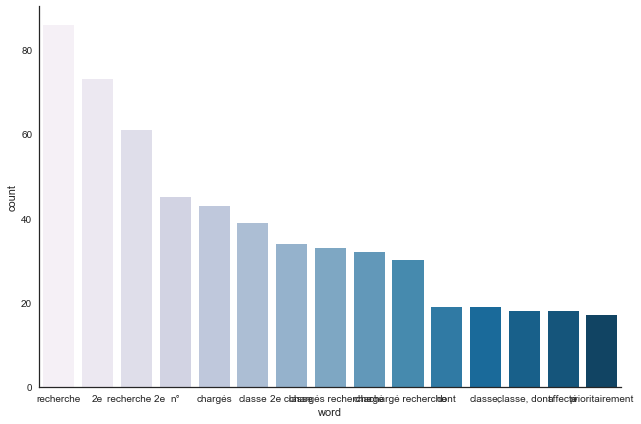

In [16]:
plotCountDf(legifrance_links, 'aafaf70cec9caed3')

## Et maintenant ?

- Listons les mots qui semblent intéressants pour qualifier un algorithme, ou ceux qui au contraire exclu directement le lien.

### Mots incluants
algorithme, cryptographie, apprentissage, automatique, 

### Mots excluants
concours, 


In [29]:
def detect_crypto(s):
    return s.startswith('crypto')

def detect_algo(s):
    return s.startswith('algo')

def detect_apprentissage(s):
    return s.startswith('apprentissage')

# Attention : "boîte de vitesse automatique, .."
def detect_automat(s):
    return s.startswith('automat')

def detect_clasification(s):
    return s.startswith('classifi')

def detect_donnees(s):
    return s.startswith('données')
# Pairwise
def detect_traitement_auto(s):
    return s.startswith('traitement auto') or s.startswith('traitements auto') or \
    s.startswith('classification auto') or s.startswith('classifications auto')  or \
    s.startswith('tri auto') or s.startswith('tris auto')  or \
    s.startswith('apprentissage auto') or s.startswith('apprentissages auto')
    
def detect_analyse_donnees(s):
    return s.startswith('analyse donnée') or s.startswith('analyses données') or\
    s.startswith('traitement données') or s.startswith('traitement donnée')

# Mots excluants
def detect_concours(s):
    return s.startswith('concour') or s.startswith('épreuve') or  s.startswith('l\'épreuve')

def detect_enseignement(s):
    return (s.startswith('enseign') or  s.startswith('l\'enseign') or  s.startswith('universit'))

In [30]:
# Incluants
legifrance_links['algo_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_algo(s[1])]))
legifrance_links['crypto_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_crypto(s[1])]))
legifrance_links['apprentissage_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_apprentissage(s[1])]))
#legifrance_links['automat_count'] = legifrance_links.sorted_freqDict.apply(
#    lambda x: sum([s[0] for s in x if detect_automat(s[1])]))
legifrance_links['classifi_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_clasification(s[1])]))
#legifrance_links['donnees_count'] = legifrance_links.sorted_freqDict.apply(
#    lambda x: sum([s[0] for s in x if detect_donnees(s[1])]))
legifrance_links['traitement_auto_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_traitement_auto(s[1])]))
legifrance_links['analyse_donnees_count'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_analyse_donnees(s[1])]))
# Excluants
legifrance_links['concours_less'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_concours(s[1])]))
legifrance_links['enseignement_less'] = legifrance_links.sorted_freqDict.apply(
    lambda x: sum([s[0] for s in x if detect_enseignement(s[1])]))

# On somme tous les mots incluants pour avoir une métrique cool
col_incluants = [col for col in legifrance_links.columns if col.endswith('_count')]
col_excluants = [col for col in legifrance_links.columns if col.endswith('_less')]

legifrance_links['score'] = legifrance_links[col_incluants].sum(axis=1)

In [45]:
mask_interesting_col = ['link', 'link_id', 'link_title', 'type_affichTexte'] + col_incluants + ['score']
legifrance_links[mask_interesting_col].describe()

,algo_count,crypto_count,apprentissage_count,classifi_count,traitement_auto_count,analyse_donnees_count,score
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,1.122363,0.540084,0.126582,0.658228,0.274262,0.185654,2.907173
std,3.966732,5.654932,0.823908,2.278600,1.035745,0.817787,8.073276
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,38.000000,84.000000,8.000000,18.000000,7.000000,8.000000,94.000000


In [46]:
legifrance_links.sort_values('score', ascending=False, inplace=True)
legifrance_links[mask_interesting_col].head(5)

,link,link_id,link_title,type_affichTexte,algo_count,crypto_count,apprentissage_count,classifi_count,traitement_auto_count,analyse_donnees_count,score
128,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000000646995,51cba9c4c5243bf0,"Décret n°2007-663 du 2 mai 2007 pris pour l'application des articles 30, 31 ...",Décret,10,84,0,0,0,0,94
141,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000024573078&...,59872c2f9bf25cb7,Arrêté du 12 juillet 2011 fixant le programme de l'enseignement de spécialit...,Arrêté,38,0,2,0,0,0,40
140,https://www.legifrance.gouv.fr/affichTexteArticle.do;jsessionid=1C2BBD119E67...,a8323115bd5ca03b,aucun_titre,Arrêté,28,0,0,4,0,0,32
142,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000000219384,ded0b832c517dab8,Arrêté du 8 août 2000 modifiant l'arrêté du 3 juillet 1995 définissant les o...,Arrêté,24,0,0,0,0,1,25
216,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000018194127&...,68af77850be1376b,Arrêté du 22 février 2008 relatif au recueil et au traitement des données d'...,Arrêté,2,0,0,18,0,5,25


In [47]:
mask_no_enseign = (legifrance_links.enseignement_less < 2) & (legifrance_links.concours_less == 0)
mask_no_crypto = (legifrance_links.crypto_count == 0)

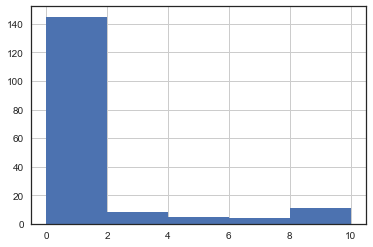

In [48]:
legifrance_links.loc[mask_no_crypto & mask_no_enseign, mask_interesting_col].score.hist(bins=5)

In [49]:
pd.options.display.max_colwidth = 80

In [58]:
legifrance_links.loc[mask_no_crypto & mask_no_enseign, mask_interesting_col].sort_values('analyse_donnees_count', ascending=False).head(2)

,link,link_id,link_title,type_affichTexte,algo_count,crypto_count,apprentissage_count,classifi_count,traitement_auto_count,analyse_donnees_count,score
209,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000031426201,9c1644353400b34b,Délibération n° 2015-162 du 4 juin 2015 portant avis sur un projet de décret...,Délibération,0,0,0,0,1,8,9
191,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000028558491,19f0dfba25d9fd61,Délibération n° 2013-221 du 18 juillet 2013 portant avis sur un projet de d...,Délibération,2,0,0,0,2,6,10


In [59]:
legifrance_links.loc[mask_no_crypto & mask_no_enseign, mask_interesting_col].head(2)

,link,link_id,link_title,type_affichTexte,algo_count,crypto_count,apprentissage_count,classifi_count,traitement_auto_count,analyse_donnees_count,score
13,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000033047753&...,a4cd4a654e5bd5ff,Délibération n° 2016-218 du 21 juillet 2016 portant avis sur un projet d'arr...,Délibération,2,0,0,0,7,1,10
66,https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000000445223,3e2b9a57b7b9a46c,Avis relatif à l'homologation et à l'annulation de normes,Avis,0,0,0,10,0,0,10


Lien: https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000033047753&categorieLien=id


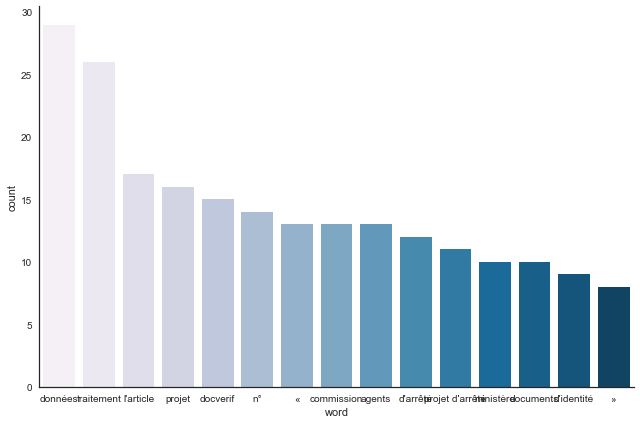

In [52]:
plotCountDf(legifrance_links, 'a4cd4a654e5bd5ff')

Lien: https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000000562959&categorieLien=id


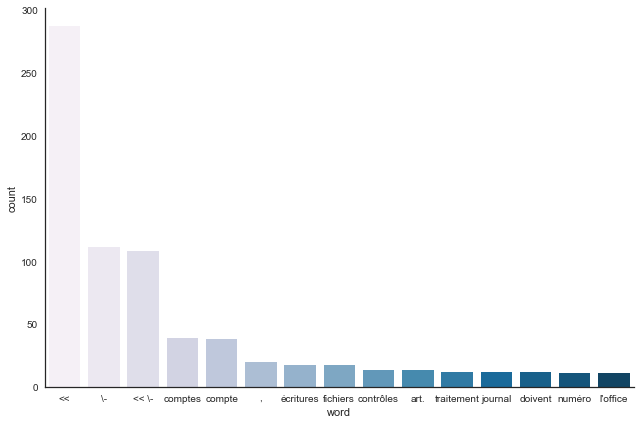

In [53]:
plotCountDf(legifrance_links, 'ac3d27bbfb90ca7b')

In [56]:
legifrance_links[mask_interesting_col].to_csv('legifrance_links_counted.csv', sep=';')